# HW 2: Clustering and Topic Models [100 points]

Run this first:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [2]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
import glob

docs = []
for f in glob.glob('./data/enron/*.txt'):
    docs.append(makeWordList(f))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=50, max_df=0.8)
X = vectorizer.fit_transform(docs).toarray()

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [5]:
from sklearn.mixture import GaussianMixture

n_clusters = 3
model = GaussianMixture(n_components=n_clusters, random_state=95865)
model.fit(X)
predicted = model.predict(X)

for i in range(n_clusters):
    print((predicted == i).sum())

3114
1414
643


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [6]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

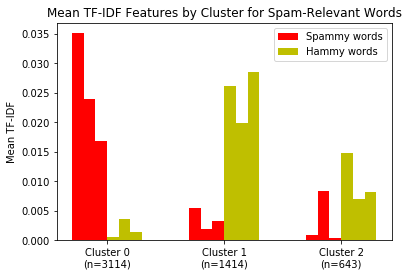

In [7]:
spammy_words = [
    'click',
    'www',
    'offer'
]

hammy_words = [
    'attached',
    'review',
    'meeting'
]

spam_indices = [vectorizer.vocabulary_[s] for s in spammy_words]
ham_indices = [vectorizer.vocabulary_[s] for s in hammy_words]

plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

According to the plot above, cluster 0 seems to correspond to spam emails while clusters 1 and 2 correspond to ham emails.

Changing the number of clusters may have either help or harm the results of the analysis, and responses will vary (especially as the results are random). The choice of n_clusters=3 seems to work well in many cases (when we fit a GMM without the `random_state` parameter).

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [7]:
import os
os.chdir('/Users/ReverieHome/PycharmProjects/Labs/95865UDA/2hw/hw2/data')

import pandas as pd
df = pd.read_csv("android.csv", sep=",",  thousands=",")

df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [18]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [16]:
X.shape

(180295, 173)

### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
X_tfidf = TfidfTransformer().fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [13]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=-1, random_state=314159265)
lda.fit(X_tfidf)

CPU times: user 45 s, sys: 3.23 s, total: 48.3 s
Wall time: 4min 25s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

**Remark on our solution code**: We actually also display the probability of the top word for its topic.

In [14]:
n_top_words = 10
feature_names = permission_columns
most_probable_words = []
for topic_idx, topic in enumerate(lda.components_):
    topic_normalized = topic / topic.sum()
    message = "Topic #%d: " % topic_idx
    message += "\n\t"
    message += "\n\t".join([feature_names[i] + ' -- prob: %f' % topic_normalized[i]
                            for i in topic_normalized.argsort()[:-n_top_words-1:-1]])
    most_probable_words.append("\n\t".join([feature_names[i]
                                            for i in topic.argsort()[:-n_top_words-1:-1]]))
    print(message)
    print()

Topic #0: 
	Phone calls : read phone state and identity (D) -- prob: 0.613382
	Network communication : full Internet access (D) -- prob: 0.119034
	Network communication : create Bluetooth connections (D) -- prob: 0.101872
	System tools : bluetooth administration (D) -- prob: 0.088623
	System tools : set wallpaper size hints (S) -- prob: 0.067876
	Network communication : view network state (S) -- prob: 0.005060
	Default : force application to close (S) -- prob: 0.000763
	Default : prevent app switches (S) -- prob: 0.000530
	Default : full Internet access (S) -- prob: 0.000502
	Default : modify/delete USB storage contents modify/delete SD card contents (S) -- prob: 0.000181

Topic #1: 
	System tools : prevent device from sleeping (D) -- prob: 0.059258
	Phone calls : read phone state and identity (D) -- prob: 0.058785
	Network communication : receive data from Internet (S) -- prob: 0.058208
	Network communication : view network state (S) -- prob: 0.057506
	Your accounts : discover known a

*** WRITE YOUR ANSWER HERE IN TEXT ***

Overall the topics don't appear that clean and clear cut. Not all the topics are interpretable. In fact, some have sufficient overlap for top words with high probability (e.g., topic 4's two top words also have somewhat high probability in topic 6).

Here are some perhaps more interpretable topics:
- Topic 2: heavily about setting the phone wallpaper (note the probability of the top word)
- Topic 3: seems to involve apps that have messaging or perhaps some sort of system-level access
- Topic 8: heavily involves controlling the phone vibrator
- Topic 9: heavily involves modifying system settings

The next part digs a bit more into interpretability by showing the top apps per topic. However, keep in mind that different apps are modeled as being composed of different amounts of multiple topics, so a top app for a topic might, for instance, also be largely about other topics as well.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

**Remark on our solution code**: We actually go ahead and show, for each topic, the top 10 apps with at least 100,000 ratings, along with each app's topic proportion within the topic.

In [15]:
topic_proportions = lda.transform(X_tfidf)
for i in range(10):
    idx = np.argsort(topic_proportions[:,i])[::-1]
    selected = app_ratings > 100000
    print("Topic #" + str(i) + ":")
    counter = 10
    for app_idx in idx:
        if counter <= 0:
            break
        if selected[app_idx] == False:
            continue
        app = app_names[app_idx]
        print("\t" + app + ' -- proportion in topic %d: %f' % (i, topic_proportions[app_idx, i]))
        counter -= 1
    print()

Topic #0:
	Blast Monkeys -- proportion in topic 0: 0.322993
	ES File Explorer -- proportion in topic 0: 0.267280
	Paradise Island -- proportion in topic 0: 0.253936
	My Country -- proportion in topic 0: 0.253936
	World Newspapers -- proportion in topic 0: 0.253936
	Pandora?? internet radio -- proportion in topic 0: 0.242494
	Pandora® internet radio -- proportion in topic 0: 0.242494
	GO Launcher EX -- proportion in topic 0: 0.100213
	LauncherPro -- proportion in topic 0: 0.062889
	Adobe Reader -- proportion in topic 0: 0.050004

Topic #1:
	Google Maps -- proportion in topic 1: 0.834332
	Evernote -- proportion in topic 1: 0.794993
	YouTube -- proportion in topic 1: 0.790459
	TiKL -- proportion in topic 1: 0.787622
	Meet New People -- proportion in topic 1: 0.774446
	Movies -- proportion in topic 1: 0.772941
	TweetCaster for Twitter -- proportion in topic 1: 0.769561
	Wordfeud FREE -- proportion in topic 1: 0.765745
	Restaurant Story™ -- proportion in topic 1: 0.727302
	Restaurant Story?

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

**Remark on our solution code**: We intentionally show results for different perplexity values (you do not have to have written your code in a loop like this) to give a sense of how the results differ. Perplexity values around ~60-80 tend to not fragment the data into two many tiny clusters and have the different colored points (corresponding to apps with different most probable topics) mostly separated out.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.868813
[t-SNE] KL divergence after 1000 iterations: -0.876630


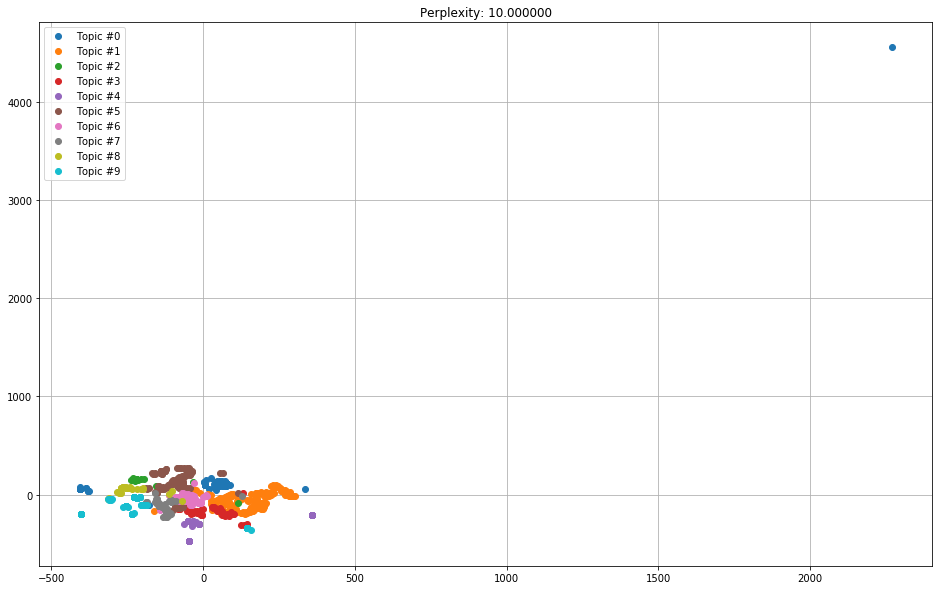

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.916733
[t-SNE] KL divergence after 1000 iterations: -0.848188


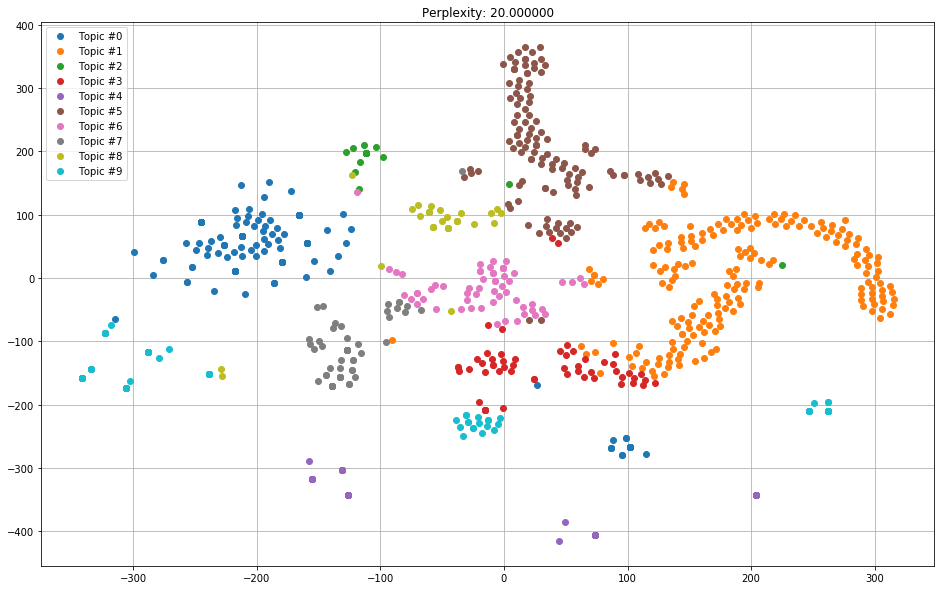

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.666275
[t-SNE] KL divergence after 1000 iterations: -0.751056


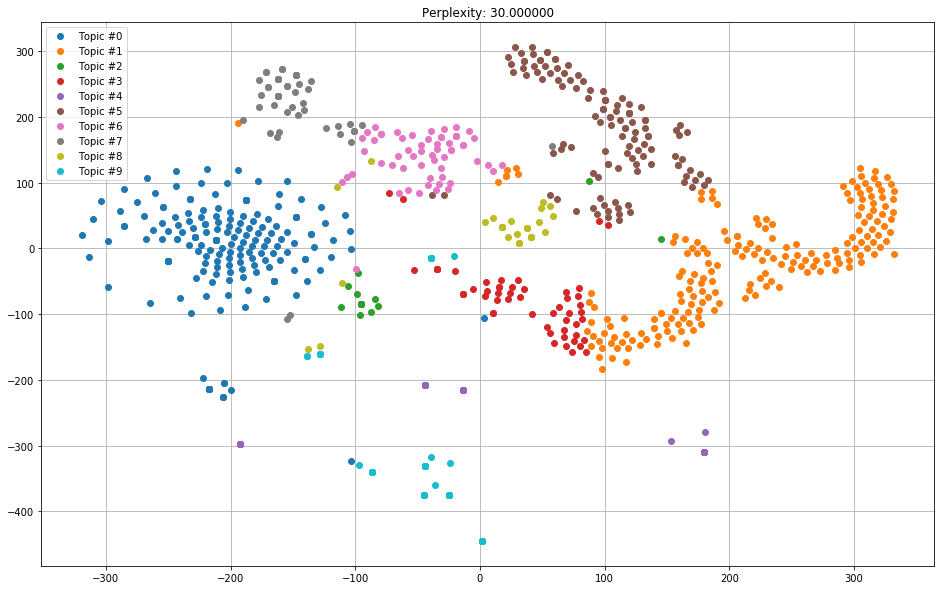

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.594978
[t-SNE] KL divergence after 1000 iterations: -0.795168


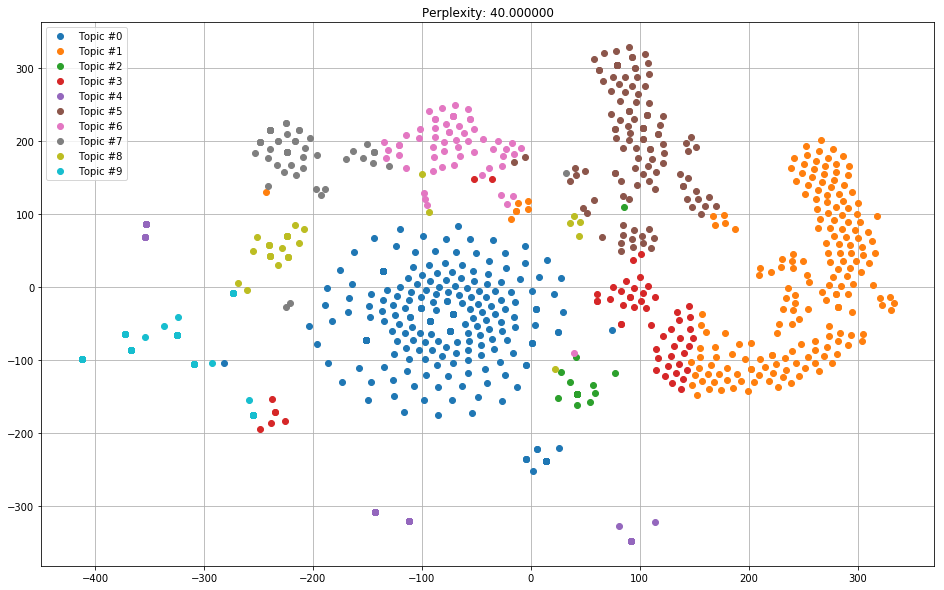

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.108547
[t-SNE] KL divergence after 1000 iterations: -1.019971


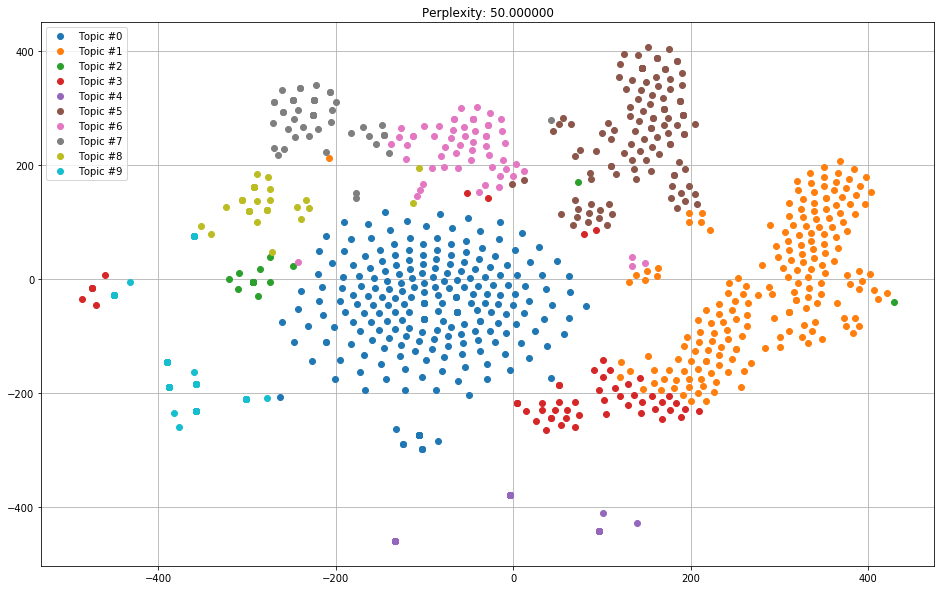

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.963341
[t-SNE] KL divergence after 1000 iterations: -0.883867


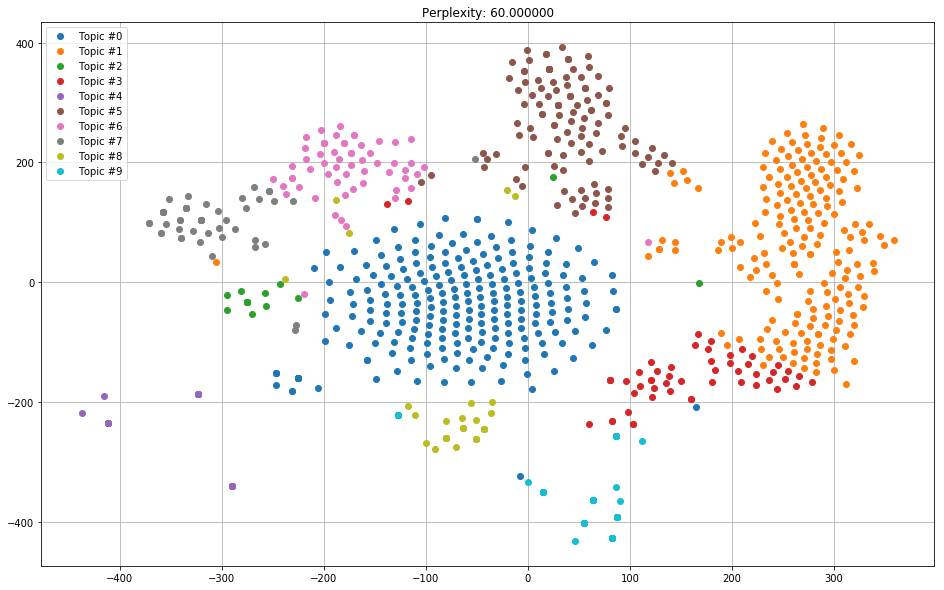

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.729027
[t-SNE] KL divergence after 1000 iterations: -0.759155


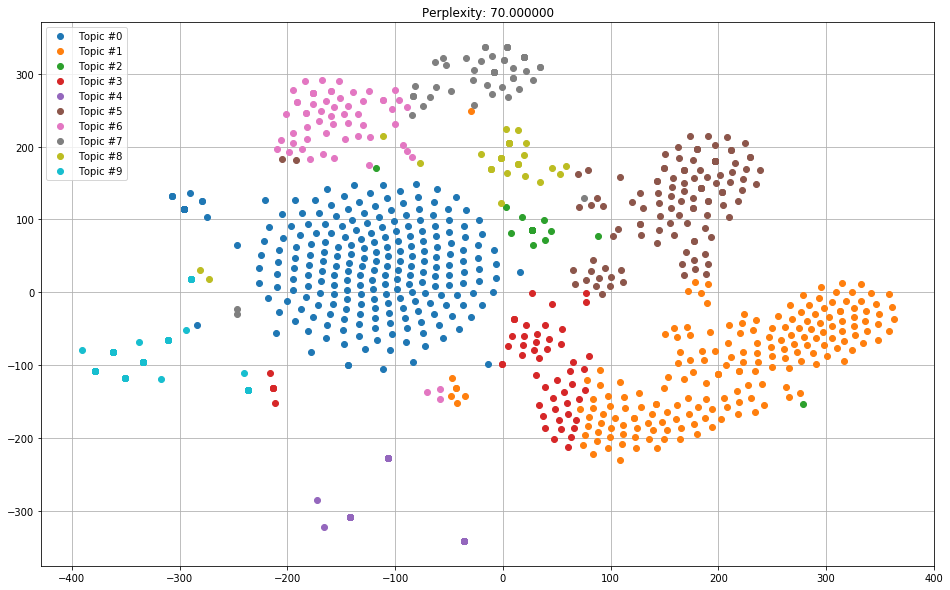

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.821037
[t-SNE] KL divergence after 1000 iterations: -0.738436


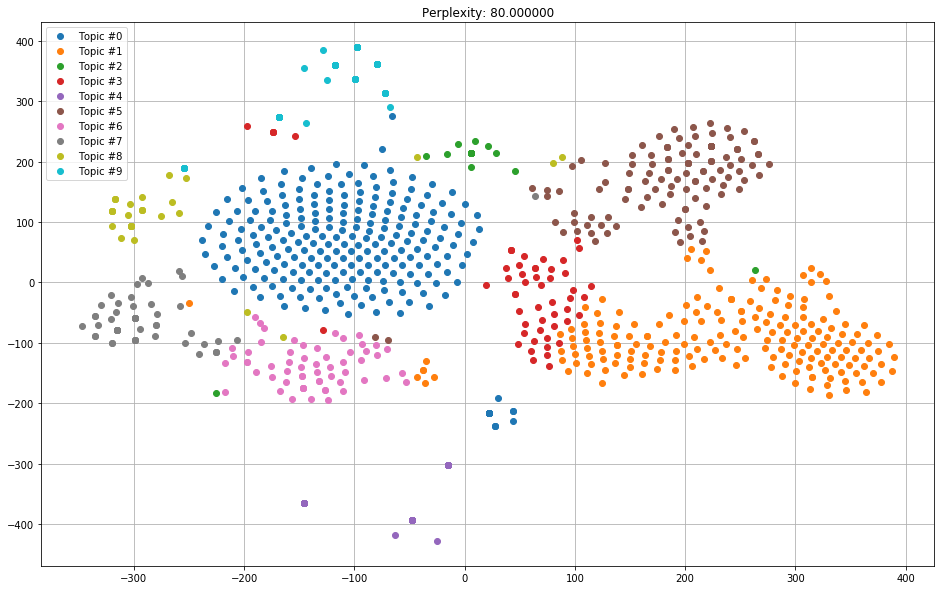

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.487698
[t-SNE] KL divergence after 1000 iterations: -0.363778


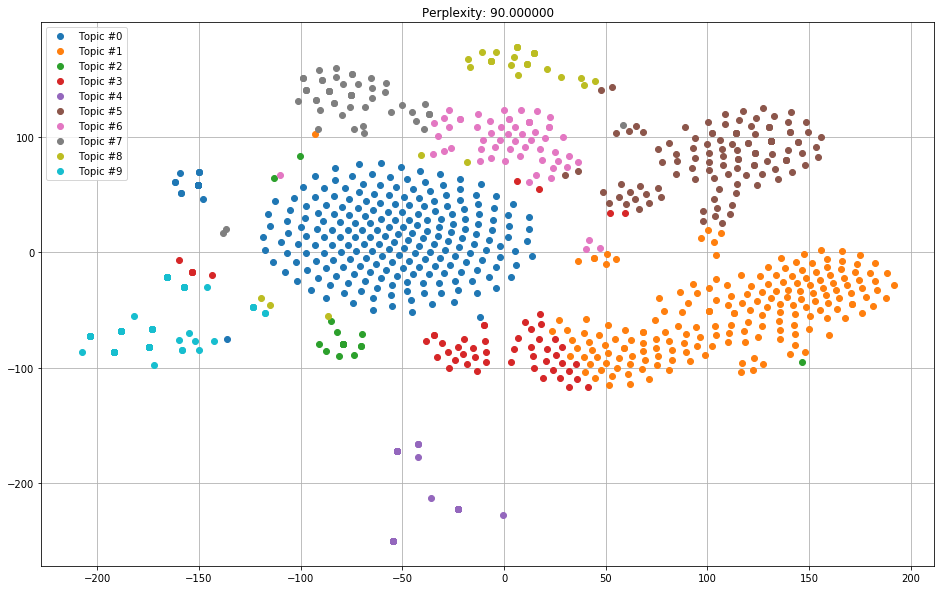

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.005543
[t-SNE] KL divergence after 1000 iterations: -0.022318


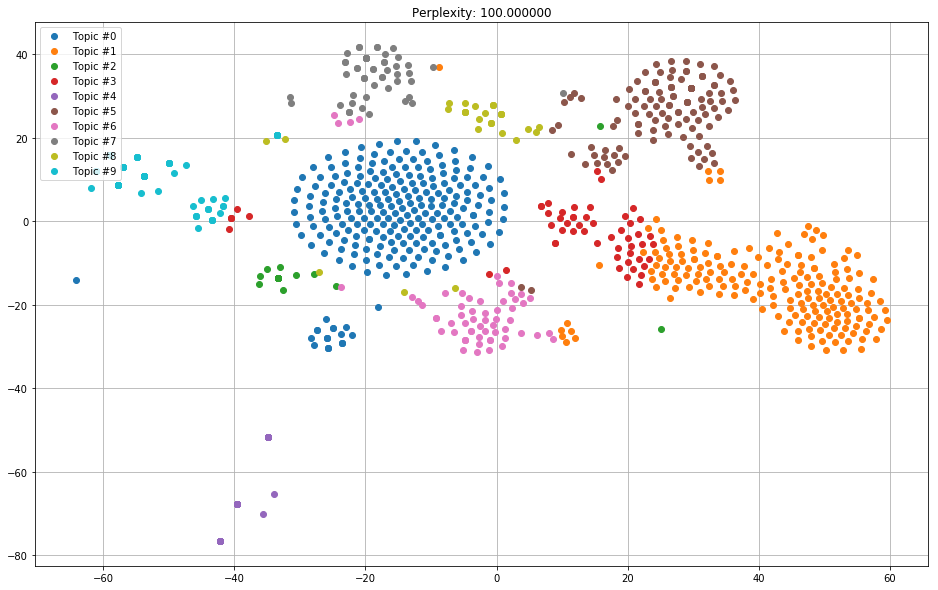

[t-SNE] Computing 999 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.756065
[t-SNE] KL divergence after 950 iterations: -0.064432


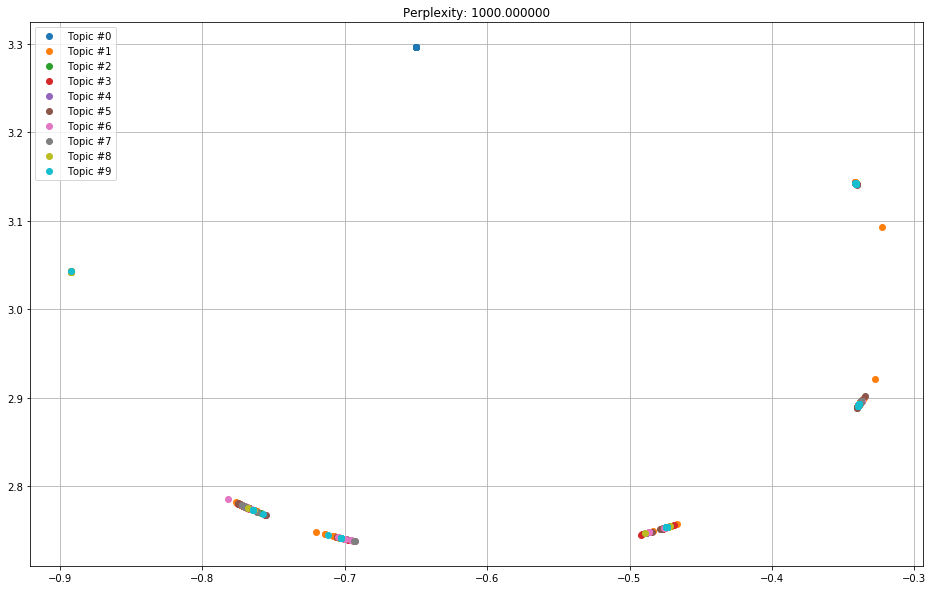

CPU times: user 1min 36s, sys: 3.13 s, total: 1min 39s
Wall time: 1min 36s


In [16]:
%%time
from sklearn.manifold import TSNE

for perplexity in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]:
    tsne_model = TSNE(n_components=2, learning_rate=800, perplexity=perplexity,
                      verbose=1, random_state=0, angle=.5, init='pca')
    topic_tsne_lda = tsne_model.fit_transform(topic_proportions[:1000,:])

    plt.figure(figsize=(16,10))
    most_probable_topic = np.argmax(topic_proportions, axis=1)[:1000]
    for t in range(10):
        plt.plot(topic_tsne_lda[most_probable_topic==t,0], topic_tsne_lda[most_probable_topic==t,1], 'o',
                 label="Topic #" + str(t))
    plt.legend(loc='upper left')
    plt.title('Perplexity: %f' % perplexity)
    plt.grid()
    plt.show()

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done both this homework *and* the mid-mini quiz: https://goo.gl/forms/pkFRGE11Xi4hzTGk1